In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, roc_curve, auc, classification_report, roc_auc_score
import matplotlib.pyplot as plt
from sklearn.svm import SVC

In [2]:
# Load the dataset
data = pd.read_csv('adult.csv')

In [3]:
# Display the first few rows and the structure of the dataset
print(data.head())
print(data.info())
print("Columns in the dataset:", data.columns.tolist())

   age  workclass  fnlwgt     education  educational-num      marital-status  \
0   25    Private  226802          11th                7       Never-married   
1   38    Private   89814       HS-grad                9  Married-civ-spouse   
2   28  Local-gov  336951    Assoc-acdm               12  Married-civ-spouse   
3   44    Private  160323  Some-college               10  Married-civ-spouse   
4   18          ?  103497  Some-college               10       Never-married   

          occupation relationship   race  gender  capital-gain  capital-loss  \
0  Machine-op-inspct    Own-child  Black    Male             0             0   
1    Farming-fishing      Husband  White    Male             0             0   
2    Protective-serv      Husband  White    Male             0             0   
3  Machine-op-inspct      Husband  Black    Male          7688             0   
4                  ?    Own-child  White  Female             0             0   

   hours-per-week native-country incom

In [4]:
# Define target and features
target = 'income'   
features = data.columns.drop([target]).tolist()

In [5]:
# Split the data into features and target
X = data[features]
y = data[target]

In [6]:
# Identify categorical and numerical columns
categorical_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()


In [7]:
# Preprocessing pipeline for numerical features
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

# Preprocessing pipeline for categorical features
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

In [8]:
# Applying Cross-Validation to Random Forest Classifier
def random_forest_cross_validation(X, y):
    model = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', RandomForestClassifier(random_state=42))
    ])
    scores = cross_val_score(model, X, y, cv=5)
    print("Random Forest Cross-Validation Scores:", scores)
    print("Mean Cross-Validation Score:", scores.mean())


In [9]:
# Investigating Overfitting and Underfitting in Gradient Boosting Machines
def gradient_boosting_analysis(X, y):
    train_scores, test_scores = [], []
    for n_estimators in [50, 100, 150, 200]:
        for learning_rate in [0.01, 0.1, 0.2, 0.3]:
            model = Pipeline(steps=[
                ('preprocessor', preprocessor),
                ('classifier', GradientBoostingClassifier(n_estimators=n_estimators, learning_rate=learning_rate, random_state=42))
            ])
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
            model.fit(X_train, y_train)
            train_scores.append(model.score(X_train, y_train))
            test_scores.append(model.score(X_test, y_test))
            print(f"n_estimators: {n_estimators}, learning_rate: {learning_rate}, Train Score: {train_scores[-1]}, Test Score: {test_scores[-1]}")

In [10]:
# Evaluating Precision, Recall, and F1-Score for Random Forests
def random_forest_metrics(X, y):
    model = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', RandomForestClassifier(random_state=42))
    ])
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print("Precision:", precision_score(y_test, y_pred, pos_label='>50K'))
    print("Recall:", recall_score(y_test, y_pred, pos_label='>50K'))
    print("F1-Score:", f1_score(y_test, y_pred, pos_label='>50K'))


In [11]:
# ROC Curve and AUC for Gradient Boosting Classifier
def gradient_boosting_roc_analysis(X, y):
    model = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', GradientBoostingClassifier(random_state=42))
    ])
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    model.fit(X_train, y_train)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba, pos_label='>50K')
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()
    print("AUC:", roc_auc)

In [12]:
# Model Performance Comparison with Different Metrics
def model_performance_comparison(X, y):
    models = [
        ('Random Forest', RandomForestClassifier(random_state=42)),
        ('Gradient Boosting', GradientBoostingClassifier(random_state=42)),
        ('SVM', SVC(probability=True, random_state=42))
    ]
    for name, model in models:
        pipeline = Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('classifier', model)
        ])
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        pipeline.fit(X_train, y_train)
        y_pred = pipeline.predict(X_test)
        y_pred_proba = pipeline.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None
        print(f"{name} Model Performance:")
        print("Accuracy:", pipeline.score(X_test, y_test))
        print("Precision:", precision_score(y_test, y_pred, pos_label='>50K'))
        print("Recall:", recall_score(y_test, y_pred, pos_label='>50K'))
        print("F1-Score:", f1_score(y_test, y_pred, pos_label='>50K'))
        if y_pred_proba is not None:
            fpr, tpr, _ = roc_curve(y_test, y_pred_proba, pos_label='>50K')
            roc_auc = auc(fpr, tpr)
            print("ROC AUC:", roc_auc)
        print(classification_report(y_test, y_pred))


In [13]:
# Applying Cross-Validation to Random Forest Classifier
random_forest_cross_validation(X, y)


Random Forest Cross-Validation Scores: [0.85146893 0.85034292 0.85053235 0.85769861 0.86046274]
Mean Cross-Validation Score: 0.8541011095034025


In [14]:
# Investigating Overfitting and Underfitting in Gradient Boosting Machines
gradient_boosting_analysis(X, y)


n_estimators: 50, learning_rate: 0.01, Train Score: 0.8035983927520283, Test Score: 0.8108301770907974
n_estimators: 50, learning_rate: 0.1, Train Score: 0.8608757965858778, Test Score: 0.8663118026410073
n_estimators: 50, learning_rate: 0.2, Train Score: 0.8686305121183426, Test Score: 0.8734773262360528
n_estimators: 50, learning_rate: 0.3, Train Score: 0.873365239423643, Test Score: 0.8776742757702938
n_estimators: 100, learning_rate: 0.01, Train Score: 0.8442914544570419, Test Score: 0.8510594738458389
n_estimators: 100, learning_rate: 0.1, Train Score: 0.8680418703452512, Test Score: 0.874091513972771
n_estimators: 100, learning_rate: 0.2, Train Score: 0.8751823509840555, Test Score: 0.8776742757702938
n_estimators: 100, learning_rate: 0.3, Train Score: 0.8795331814808179, Test Score: 0.8785955573753711
n_estimators: 150, learning_rate: 0.01, Train Score: 0.8468251733933918, Test Score: 0.8535162247927116
n_estimators: 150, learning_rate: 0.1, Train Score: 0.8720599902746142, Test

In [15]:
# Evaluating Precision, Recall, and F1-Score for Random Forests
random_forest_metrics(X, y)


Precision: 0.7281265447355413
Recall: 0.643231441048035
F1-Score: 0.6830512404358915


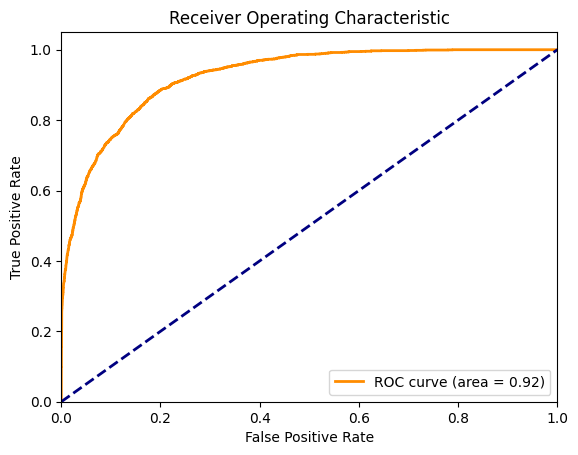

AUC: 0.9247968839679779


In [16]:
# ROC Curve and AUC for Gradient Boosting Classifier
gradient_boosting_roc_analysis(X, y)


In [17]:
# Model Performance Comparison with Different Metrics
model_performance_comparison(X, y)

Random Forest Model Performance:
Accuracy: 0.860067560651039
Precision: 0.7281265447355413
Recall: 0.643231441048035
F1-Score: 0.6830512404358915
ROC AUC: 0.9074853549180792
              precision    recall  f1-score   support

       <=50K       0.89      0.93      0.91      7479
        >50K       0.73      0.64      0.68      2290

    accuracy                           0.86      9769
   macro avg       0.81      0.78      0.80      9769
weighted avg       0.86      0.86      0.86      9769

Gradient Boosting Model Performance:
Accuracy: 0.874091513972771
Precision: 0.7941176470588235
Recall: 0.6248908296943232
F1-Score: 0.6994134897360704
ROC AUC: 0.9247968839679779
              precision    recall  f1-score   support

       <=50K       0.89      0.95      0.92      7479
        >50K       0.79      0.62      0.70      2290

    accuracy                           0.87      9769
   macro avg       0.84      0.79      0.81      9769
weighted avg       0.87      0.87      0.87     